# AIVLE스쿨 2차 미니프로젝트: 신규 아파트 주차 수요 예측

<img src = "https://github.com/Jangrae/img/blob/master/parking.png?raw=true" width=800, align="left"/>

# 단계 1: 데이터 전처리

## [미션]

단지별 등록 차량 수를 예측하기에 적합한 형태로 데이터 전처리를 수행합니다.

1) 필요한 변수를 추가하고 불필요한 변수를 제거합니다.
2) 단지별 데이터와 상세 데이터를 분리합니다.
3) 상세 데이터를 단지별로 집계합니다.
    - 단지별 총면적 집계
    - 전용면적구간 집계 (피벗형태)
    - 단지별 임대보증금, 임대료 평균 집계
4) 단지별 데이터와 집계 데이터를 하나로 합칩니다.
5) 변수 추가 (옵션)
    - 등록 차량수를 예측하기 위해 필요한 변수를 추가합니다.

## 1. 환경설정

### (1) 로컬 수행(Anaconda)

- project 폴더에 필요한 파일들을 넣고, 본 파일을 열었다면, 별도 경로 지정이 필요하지 않습니다.

In [9]:
# 기본 경로
path = ''

### (2) 구글 콜랩 수행

- 구글 콜랩을 사용중이면 구글 드라이브를 연결합니다.

In [11]:
# 구글 드라이브 연결, 패스 지정
import sys
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    path = '/content/drive/MyDrive/project/'

### (3) 한글 폰트 표시용 라이브러리 설치

In [13]:
# 한글 표시를 위한 라이브러리 설치
!pip install koreanize_matplotlib -q

### (4) 라이브러리 불러오기

In [15]:
# 라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns

import joblib
import warnings

warnings.filterwarnings(action='ignore')
%config InlineBackend.figure_format='retina'

### (5) 데이터 불러오기

- 학습용 데이터(train.xlsx)를 읽어옵니다.
- 읽어온 데이터를 apart 데이터프레임으로 선언합니다.
- 평가용 데이터(test.xlsx) 파일은 모델 완성 후 사용할 미래의 데이터입니다.

#### 1) 데이터 불러오기

In [18]:
# 파일 불러오기
apart = pd.read_excel(path+'train.xlsx')

#### 2) 기본 정보 조회

In [20]:
apart.head()


,단지코드,단지명,총세대수,전용면적별세대수,지역,준공일자,건물형태,난방방식,승강기설치여부,단지내주차면수,전용면적,공용면적,임대보증금,임대료,실차량수
0,C0001,엘에이치 서초4단지,78,35,서울,20131204,계단식,개별가스난방,전체동 설치,120,51.89,19.2603,50758000,620370,109
1,C0001,엘에이치 서초4단지,78,43,서울,20131204,계단식,개별가스난방,전체동 설치,120,59.93,22.2446,63166000,665490,109
2,C0002,LH삼성아파트,35,26,서울,20130801,복도식,개별가스난방,전체동 설치,47,27.75,16.5375,63062000,458640,35
3,C0002,LH삼성아파트,35,9,서울,20130801,복도식,개별가스난방,전체동 설치,47,29.08,17.3302,63062000,481560,35
4,C0003,강남LH8단지,88,7,서울,20131023,계단식,개별가스난방,전체동 설치,106,59.47,21.9462,72190000,586540,88


In [21]:
apart

,단지코드,단지명,총세대수,전용면적별세대수,지역,준공일자,건물형태,난방방식,승강기설치여부,단지내주차면수,전용면적,공용면적,임대보증금,임대료,실차량수
0,C0001,엘에이치 서초4단지,78,35,서울,20131204,계단식,개별가스난방,전체동 설치,120,51.89,19.2603,50758000,620370,109
1,C0001,엘에이치 서초4단지,78,43,서울,20131204,계단식,개별가스난방,전체동 설치,120,59.93,22.2446,63166000,665490,109
2,C0002,LH삼성아파트,35,26,서울,20130801,복도식,개별가스난방,전체동 설치,47,27.75,16.5375,63062000,458640,35
3,C0002,LH삼성아파트,35,9,서울,20130801,복도식,개별가스난방,전체동 설치,47,29.08,17.3302,63062000,481560,35
4,C0003,강남LH8단지,88,7,서울,20131023,계단식,개별가스난방,전체동 설치,106,59.47,21.9462,72190000,586540,88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1152,C0356,덕유마을 주공1단지,956,956,경기,19941130,복도식,지역가스난방,전체동 설치,202,26.37,12.7500,9931000,134540,243
1153,C0358,화천신읍(공공실버) 영구임대,120,66,강원,20200110,복도식,NaN,전체동 설치,40,24.83,15.1557,2129000,42350,47
1154,C0358,화천신읍(공공실버) 영구임대,120,54,강원,20200110,복도식,NaN,전체동 설치,40,33.84,20.6553,2902000,57730,47
1155,C0359,영천야사4,447,149,대구경북,19940615,복도식,중앙유류난방,전체동 설치,89,26.37,13.3800,7134000,118880,78


In [22]:
apart.describe()


,총세대수,전용면적별세대수,준공일자,단지내주차면수,전용면적,공용면적,임대보증금,임대료,실차량수
count,1157.000000,1157.000000,1.157000e+03,1157.000000,1157.000000,1157.000000,1.157000e+03,1.157000e+03,1157.000000
mean,659.075194,163.691443,2.008667e+07,682.261884,51.565584,20.562360,2.850789e+07,2.259409e+05,650.762316
std,456.110643,166.766358,6.777985e+04,473.331805,18.243315,5.164405,2.890687e+07,1.768102e+05,390.573462
min,1.000000,1.000000,1.992010e+07,10.000000,17.590000,5.850000,0.000000e+00,0.000000e+00,21.000000
25%,315.000000,44.000000,2.005031e+07,308.000000,39.480000,16.997400,1.379700e+07,1.177400e+05,320.000000
50%,595.000000,112.000000,2.010042e+07,629.000000,46.900000,20.384700,1.997300e+07,1.842900e+05,626.000000
75%,918.000000,229.000000,2.013121e+07,911.000000,59.810000,23.722500,3.375300e+07,2.634400e+05,894.000000
max,2289.000000,1258.000000,2.022071e+07,4553.000000,139.350000,42.760000,2.549220e+08,1.058030e+06,1657.000000


In [23]:
apart.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1157 entries, 0 to 1156
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   단지코드      1157 non-null   object 
 1   단지명       1157 non-null   object 
 2   총세대수      1157 non-null   int64  
 3   전용면적별세대수  1157 non-null   int64  
 4   지역        1157 non-null   object 
 5   준공일자      1157 non-null   int64  
 6   건물형태      1135 non-null   object 
 7   난방방식      1082 non-null   object 
 8   승강기설치여부   1059 non-null   object 
 9   단지내주차면수   1157 non-null   int64  
 10  전용면적      1157 non-null   float64
 11  공용면적      1157 non-null   float64
 12  임대보증금     1157 non-null   int64  
 13  임대료       1157 non-null   int64  
 14  실차량수      1157 non-null   int64  
dtypes: float64(2), int64(7), object(6)
memory usage: 135.7+ KB


## 2. 데이터 전처리 ①

- 결측치 존재 여부를 확인하고 적절히 처리합니다.
- 필요한 변수를 추가하고, 불필요한 변수를 제거합니다.

### (1) 결측치 처리

- 결측치가 있는 지 확인합니다.

In [26]:
apart.isna().sum()


단지코드         0
단지명          0
총세대수         0
전용면적별세대수     0
지역           0
준공일자         0
건물형태        22
난방방식        75
승강기설치여부     98
단지내주차면수      0
전용면적         0
공용면적         0
임대보증금        0
임대료          0
실차량수         0
dtype: int64

- 결측치는 적절한 값으로 채웁니다.
- 예를 들어 범주형 변수인 경우는 각 변수의 최빈값으로 채울 수 있습니다.

In [28]:
apart['건물형태'].mode()[0]
apart['건물형태'].fillna(apart['건물형태'].mode()[0],inplace=True)


In [29]:
apart['난방방식'].mode()[0]
apart['난방방식'].fillna(apart['난방방식'].mode()[0],inplace=True)

In [30]:
apart['승강기설치여부'].value_counts()
apart['승강기설치여부'].fillna(apart['승강기설치여부'].mode()[0],inplace=True)

In [31]:
apart.isna().sum()

단지코드        0
단지명         0
총세대수        0
전용면적별세대수    0
지역          0
준공일자        0
건물형태        0
난방방식        0
승강기설치여부     0
단지내주차면수     0
전용면적        0
공용면적        0
임대보증금       0
임대료         0
실차량수        0
dtype: int64

### (2) 변수 추가

- '준공일자' 변수 값 앞 4 자리를 갖는 int 형 변수 '준공연도'를 추가합니다.
- 총면적 = (전용면적 + 공용면적) * 전용면적별세대수 공식에 따른'총면적' 변수를 추가합니다.

In [33]:
apart['준공연도'] = [int(day/10000) for day in apart['준공일자']]

apart

,단지코드,단지명,총세대수,전용면적별세대수,지역,준공일자,건물형태,난방방식,승강기설치여부,단지내주차면수,전용면적,공용면적,임대보증금,임대료,실차량수,준공연도
0,C0001,엘에이치 서초4단지,78,35,서울,20131204,계단식,개별가스난방,전체동 설치,120,51.89,19.2603,50758000,620370,109,2013
1,C0001,엘에이치 서초4단지,78,43,서울,20131204,계단식,개별가스난방,전체동 설치,120,59.93,22.2446,63166000,665490,109,2013
2,C0002,LH삼성아파트,35,26,서울,20130801,복도식,개별가스난방,전체동 설치,47,27.75,16.5375,63062000,458640,35,2013
3,C0002,LH삼성아파트,35,9,서울,20130801,복도식,개별가스난방,전체동 설치,47,29.08,17.3302,63062000,481560,35,2013
4,C0003,강남LH8단지,88,7,서울,20131023,계단식,개별가스난방,전체동 설치,106,59.47,21.9462,72190000,586540,88,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1152,C0356,덕유마을 주공1단지,956,956,경기,19941130,복도식,지역가스난방,전체동 설치,202,26.37,12.7500,9931000,134540,243,1994
1153,C0358,화천신읍(공공실버) 영구임대,120,66,강원,20200110,복도식,개별가스난방,전체동 설치,40,24.83,15.1557,2129000,42350,47,2020
1154,C0358,화천신읍(공공실버) 영구임대,120,54,강원,20200110,복도식,개별가스난방,전체동 설치,40,33.84,20.6553,2902000,57730,47,2020
1155,C0359,영천야사4,447,149,대구경북,19940615,복도식,중앙유류난방,전체동 설치,89,26.37,13.3800,7134000,118880,78,1994


### (3) 불필요한 변수 제거

- '단지명' 변수는 단일값을 가지므로 제거합니다.
- '단지내주차면수' 변숫값을 기반으로 등록 차량수를 예측하는 것은 의미가 없으니, '단지내주차면수' 변수를 제거합니다.
- '준공연도' 변수를 추가했으니 '준공일자' 변수를 제거합니다.

In [35]:
drop_col = ['단지명','단지내주차면수','준공일자']
apart.drop(drop_col,axis=1,inplace=True)
apart

,단지코드,총세대수,전용면적별세대수,지역,건물형태,난방방식,승강기설치여부,전용면적,공용면적,임대보증금,임대료,실차량수,준공연도
0,C0001,78,35,서울,계단식,개별가스난방,전체동 설치,51.89,19.2603,50758000,620370,109,2013
1,C0001,78,43,서울,계단식,개별가스난방,전체동 설치,59.93,22.2446,63166000,665490,109,2013
2,C0002,35,26,서울,복도식,개별가스난방,전체동 설치,27.75,16.5375,63062000,458640,35,2013
3,C0002,35,9,서울,복도식,개별가스난방,전체동 설치,29.08,17.3302,63062000,481560,35,2013
4,C0003,88,7,서울,계단식,개별가스난방,전체동 설치,59.47,21.9462,72190000,586540,88,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1152,C0356,956,956,경기,복도식,지역가스난방,전체동 설치,26.37,12.7500,9931000,134540,243,1994
1153,C0358,120,66,강원,복도식,개별가스난방,전체동 설치,24.83,15.1557,2129000,42350,47,2020
1154,C0358,120,54,강원,복도식,개별가스난방,전체동 설치,33.84,20.6553,2902000,57730,47,2020
1155,C0359,447,149,대구경북,복도식,중앙유류난방,전체동 설치,26.37,13.3800,7134000,118880,78,1994


## 3. 데이터 전처리 ②

- 단지별 데이터와 상세 데이터로 분리합니다.
- 상세 데이터를 3가지 형태로 집계합니다.
- 단지별 데이터와 상세 데이터 집계 결과를 조인(Merge) 합니다.

### (1) 데이터 분리

- 단지별 데이터를 갖는 data01 데이터프레임을 선언합니다.
- 상세 데이터를 갖는 data02 데이터프레임을 선언합니다.

#### 1) 단지별 데이터 분리

- 다음 열을 갖는 data01 데이터프레임으로 선언합니다.
    - '단지코드', '총세대수', '지역', '준공연도', '건물형태', '난방방식', '승강기설치여부', '실차량수'
- data01 데이터프레임의 중복행을 제거합니다.
- 인덱스를 초기화 합니다. (단, 기존 인덱스 제거)
- 중복행 제거 여부를 필히 확인합니다.

In [39]:
data01 = apart[['단지코드', '총세대수', '지역', '준공연도', '건물형태', '난방방식', '승강기설치여부', '실차량수']]
data01

,단지코드,총세대수,지역,준공연도,건물형태,난방방식,승강기설치여부,실차량수
0,C0001,78,서울,2013,계단식,개별가스난방,전체동 설치,109
1,C0001,78,서울,2013,계단식,개별가스난방,전체동 설치,109
2,C0002,35,서울,2013,복도식,개별가스난방,전체동 설치,35
3,C0002,35,서울,2013,복도식,개별가스난방,전체동 설치,35
4,C0003,88,서울,2013,계단식,개별가스난방,전체동 설치,88
...,...,...,...,...,...,...,...,...
1152,C0356,956,경기,1994,복도식,지역가스난방,전체동 설치,243
1153,C0358,120,강원,2020,복도식,개별가스난방,전체동 설치,47
1154,C0358,120,강원,2020,복도식,개별가스난방,전체동 설치,47
1155,C0359,447,대구경북,1994,복도식,중앙유류난방,전체동 설치,78


In [40]:
data01.drop_duplicates(inplace=True)
data01.reset_index(drop=True,inplace=True)
data01

,단지코드,총세대수,지역,준공연도,건물형태,난방방식,승강기설치여부,실차량수
0,C0001,78,서울,2013,계단식,개별가스난방,전체동 설치,109
1,C0002,35,서울,2013,복도식,개별가스난방,전체동 설치,35
2,C0003,88,서울,2013,계단식,개별가스난방,전체동 설치,88
3,C0004,477,서울,2014,복도식,지역난방,전체동 설치,943
4,C0006,15,서울,2013,복도식,개별가스난방,전체동 설치,21
...,...,...,...,...,...,...,...,...
340,C0354,1485,대전충남,1993,복도식,중앙난방,전체동 설치,298
341,C1354,1386,대전충남,1993,복도식,중앙가스난방,전체동 설치,258
342,C0356,956,경기,1994,복도식,지역가스난방,전체동 설치,243
343,C0358,120,강원,2020,복도식,개별가스난방,전체동 설치,47


#### 2) 상세 데이터 분리
    
- 다음 열을 갖는 data02 데이터프레임으로 선언합니다.
    - '단지코드', '총면적',  '전용면적별세대수', '전용면적', '공용면적', '임대보증금', '임대료'

In [42]:
data02=apart[['단지코드','전용면적별세대수', '전용면적', '공용면적', '임대보증금', '임대료']]
data02['총면적']=(data02['전용면적']+data02['공용면적'])*data02['전용면적별세대수']
data02

,단지코드,전용면적별세대수,전용면적,공용면적,임대보증금,임대료,총면적
0,C0001,35,51.89,19.2603,50758000,620370,2490.2605
1,C0001,43,59.93,22.2446,63166000,665490,3533.5078
2,C0002,26,27.75,16.5375,63062000,458640,1151.4750
3,C0002,9,29.08,17.3302,63062000,481560,417.6918
4,C0003,7,59.47,21.9462,72190000,586540,569.9134
...,...,...,...,...,...,...,...
1152,C0356,956,26.37,12.7500,9931000,134540,37398.7200
1153,C0358,66,24.83,15.1557,2129000,42350,2639.0562
1154,C0358,54,33.84,20.6553,2902000,57730,2942.7462
1155,C0359,149,26.37,13.3800,7134000,118880,5922.7500


### (2) 상세 데이터 집계

- 앞에서 선언한 data02 데이터프레임을 대상으로 다음 3가지 형태로 집계합니다.
    - 단지코드별 총면적 합을 집계합니다.
    - 전용면적을 의미있는 구간으로 나누어 피벗 형태로 집계합니다.
    - 단지코드별 임대보증금, 임대료 평균을 집계합니다

#### 1) 단지코드별 총면적 합 집계

- 단지코드별 총면적 합을 집계합니다.
- 집계한 결과를 df_area 데이터프레임으로 선언합니다.

In [45]:
df_area = data02.groupby('단지코드').sum()[['총면적']]
df_area.reset_index(inplace=True)
df_area

,단지코드,총면적
0,C0001,6023.7683
1,C0002,1569.1668
2,C0003,7180.1396
3,C0004,47058.9273
4,C0006,543.0268
...,...,...
340,C1341,5143.4140
341,C1354,57616.8100
342,C2307,7605.3580
343,C2343,3284.9760


#### 2) 전용면적 구간별 집계 (피벗 형태)

- data02 데이터프레임에 전용면적을 몇몇 구간으로 나눈 범줏값을 갖는 변수를 추가합니다.
- 구간을 어떻게 나눌 지 충분히 고민해 봅니다.
    - 구간 예: 10-30, 30-40, 40-50, 50-60, 60-70, 70-80, 80-200 
- 추가할 변수 이름은 '전용면적구간'으로 합니다.
- 참고: pd.cut() 함수를 활용합니다.

In [47]:
data02.describe()


,전용면적별세대수,전용면적,공용면적,임대보증금,임대료,총면적
count,1157.000000,1157.000000,1157.000000,1.157000e+03,1.157000e+03,1157.000000
mean,163.691443,51.565584,20.562360,2.850789e+07,2.259409e+05,11117.129107
std,166.766358,18.243315,5.164405,2.890687e+07,1.768102e+05,11417.523851
min,1.000000,17.590000,5.850000,0.000000e+00,0.000000e+00,30.095500
25%,44.000000,39.480000,16.997400,1.379700e+07,1.177400e+05,3070.670200
50%,112.000000,46.900000,20.384700,1.997300e+07,1.842900e+05,7734.663000
75%,229.000000,59.810000,23.722500,3.375300e+07,2.634400e+05,15042.642300
max,1258.000000,139.350000,42.760000,2.549220e+08,1.058030e+06,90472.674100


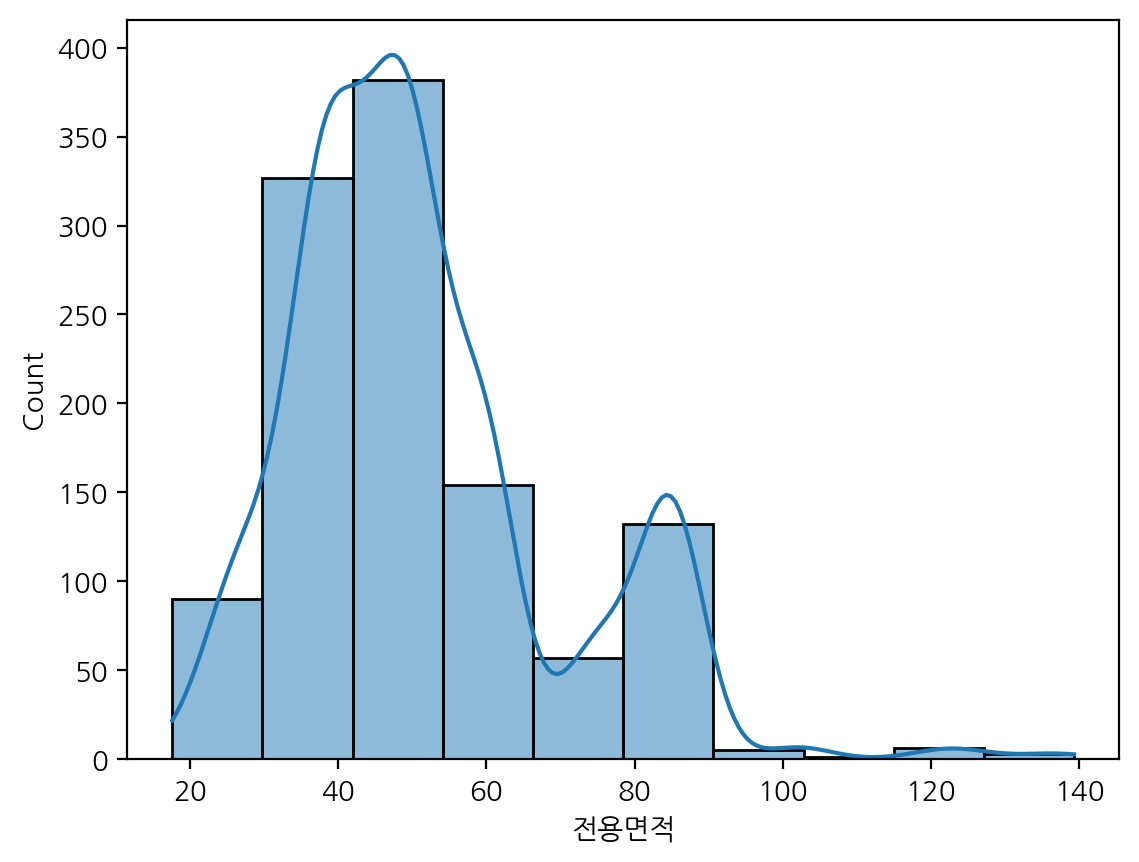

In [48]:
sns.histplot(data02['전용면적'],kde=True,bins=10)
plt.show()

In [49]:
labels = ['1030', '3040', '4050', '5060', '6070', '7080', '80200']
data02['전용면적구간'] = pd.cut(data02['전용면적'], bins=[10,30,40,50,60,70,80,200], labels=labels)
data02

,단지코드,전용면적별세대수,전용면적,공용면적,임대보증금,임대료,총면적,전용면적구간
0,C0001,35,51.89,19.2603,50758000,620370,2490.2605,5060
1,C0001,43,59.93,22.2446,63166000,665490,3533.5078,5060
2,C0002,26,27.75,16.5375,63062000,458640,1151.4750,1030
3,C0002,9,29.08,17.3302,63062000,481560,417.6918,1030
4,C0003,7,59.47,21.9462,72190000,586540,569.9134,5060
...,...,...,...,...,...,...,...,...
1152,C0356,956,26.37,12.7500,9931000,134540,37398.7200,1030
1153,C0358,66,24.83,15.1557,2129000,42350,2639.0562,1030
1154,C0358,54,33.84,20.6553,2902000,57730,2942.7462,3040
1155,C0359,149,26.37,13.3800,7134000,118880,5922.7500,1030


- 단지코드, 전용면적구간별 전용면적별세대수 합을 집계합니다.
- 집계 결과를 temp 데이터프레임으로 선언합니다.

In [51]:
temp = data02.groupby(['단지코드','전용면적구간']).sum()[['전용면적별세대수']]
temp.tail(10)


전용면적별세대수
단지코드  전용면적구간          
C2343 6070           0
      7080           0
      80200          0
C2349 1030          40
      3040           0
      4050           0
      5060           0
      6070           0
      7080           0
      80200          0

- temp 데이터프레임을 피벗 형태로 변환하여 df_pivot 데이터프레임으로 선언합니다.
- 인덱스를 초기화합니다. (단, 인덱스였던 '단지코드'가 제거되면 안됨)
- 이후 작업의 편의를 위해 일반적인 데이터프레임 형태를 갖게 합니다.
- 참고: df2 = df1.pivot(index=?, columns=?, values=?) 형태로 pivot() 메서드를 사용합니다.
- 참고: df2.columns.name=None 형태의 구문을 사용해 열이름에 대한 이름을 제거합니다.

In [53]:
df_pivot = temp.pivot_table(index='단지코드',columns='전용면적구간',values='전용면적별세대수')
df_pivot.columns.name=None
df_pivot.reset_index(inplace=True)
df_pivot['1030'] = [int(a) for a in df_pivot['1030']]
df_pivot['3040'] = [int(a) for a in df_pivot['3040']]
df_pivot['4050'] = [int(a) for a in df_pivot['4050']]
df_pivot['5060'] = [int(a) for a in df_pivot['5060']]
df_pivot['6070'] = [int(a) for a in df_pivot['6070']]
df_pivot['7080'] = [int(a) for a in df_pivot['7080']]
df_pivot['80200'] = [int(a) for a in df_pivot['80200']]
df_pivot

,단지코드,1030,3040,4050,5060,6070,7080,80200
0,C0001,0,0,0,78,0,0,0
1,C0002,35,0,0,0,0,0,0
2,C0003,0,0,0,88,0,0,0
3,C0004,0,0,0,150,0,216,111
4,C0006,15,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
340,C1341,140,0,0,0,0,0,0
341,C1354,1071,298,0,17,0,0,0
342,C2307,196,0,0,0,0,0,0
343,C2343,80,0,0,0,0,0,0


#### 3) 임대보증금, 임대료 평균 집계

- 단지코드별 임대보증금, 임대료 평균을 집계합니다.
- 집계 결과를 df_rent 데이터프레임으로 선언합니다.

In [55]:
df_rent = data02.groupby('단지코드')[['임대보증금','임대료']].mean()
df_rent.reset_index()


,단지코드,임대보증금,임대료
0,C0001,5.696200e+07,642930.000000
1,C0002,6.306200e+07,470100.000000
2,C0003,7.219000e+07,586540.000000
3,C0004,1.015167e+08,950305.000000
4,C0006,5.522750e+07,340148.333333
...,...,...,...
340,C1341,1.188600e+07,93000.000000
341,C1354,8.092875e+06,111848.750000
342,C2307,1.180250e+07,94055.000000
343,C2343,1.211700e+07,108000.000000


### (3) 집계 결과 합치기

- 위 과정에서 만든 df_area, df_pivot, df_rent 데이터프레임을 data01 데이터프레임과 조인(Merge)합니다.
- data01 데이터프레임이 기준 데이터프레임입니다.
- '단지코드' 변수가 조인 기준이 되며, how='left'를 지정합니다.
- 조인 결과를 base_data 데이터프레임으로 선언합니다.

In [57]:
data01.reset_index()
data01

,단지코드,총세대수,지역,준공연도,건물형태,난방방식,승강기설치여부,실차량수
0,C0001,78,서울,2013,계단식,개별가스난방,전체동 설치,109
1,C0002,35,서울,2013,복도식,개별가스난방,전체동 설치,35
2,C0003,88,서울,2013,계단식,개별가스난방,전체동 설치,88
3,C0004,477,서울,2014,복도식,지역난방,전체동 설치,943
4,C0006,15,서울,2013,복도식,개별가스난방,전체동 설치,21
...,...,...,...,...,...,...,...,...
340,C0354,1485,대전충남,1993,복도식,중앙난방,전체동 설치,298
341,C1354,1386,대전충남,1993,복도식,중앙가스난방,전체동 설치,258
342,C0356,956,경기,1994,복도식,지역가스난방,전체동 설치,243
343,C0358,120,강원,2020,복도식,개별가스난방,전체동 설치,47


In [58]:

base_data = pd.merge(data01,df_area,how='left',on='단지코드')
base_data = pd.merge(base_data, df_pivot,how='left',on='단지코드')
base_data = pd.merge(base_data, df_rent,how='left',on='단지코드')

base_data



,단지코드,총세대수,지역,준공연도,건물형태,난방방식,승강기설치여부,실차량수,총면적,1030,3040,4050,5060,6070,7080,80200,임대보증금,임대료
0,C0001,78,서울,2013,계단식,개별가스난방,전체동 설치,109,6023.7683,0,0,0,78,0,0,0,5.696200e+07,642930.000000
1,C0002,35,서울,2013,복도식,개별가스난방,전체동 설치,35,1569.1668,35,0,0,0,0,0,0,6.306200e+07,470100.000000
2,C0003,88,서울,2013,계단식,개별가스난방,전체동 설치,88,7180.1396,0,0,0,88,0,0,0,7.219000e+07,586540.000000
3,C0004,477,서울,2014,복도식,지역난방,전체동 설치,943,47058.9273,0,0,0,150,0,216,111,1.015167e+08,950305.000000
4,C0006,15,서울,2013,복도식,개별가스난방,전체동 설치,21,543.0268,15,0,0,0,0,0,0,5.522750e+07,340148.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340,C0354,1485,대전충남,1993,복도식,중앙난방,전체동 설치,298,64622.2500,1181,298,0,6,0,0,0,7.595571e+06,104975.714286
341,C1354,1386,대전충남,1993,복도식,중앙가스난방,전체동 설치,258,57616.8100,1071,298,0,17,0,0,0,8.092875e+06,111848.750000
342,C0356,956,경기,1994,복도식,지역가스난방,전체동 설치,243,37398.7200,956,0,0,0,0,0,0,9.931000e+06,134540.000000
343,C0358,120,강원,2020,복도식,개별가스난방,전체동 설치,47,5581.8024,66,54,0,0,0,0,0,2.515500e+06,50040.000000


## 4. 데이터 셋 저장

- joblib.dump() 함수를 사용하여 최종 데이터 셋을 파일로 저장합니다.
- 파일 이름은 base_data1.pkl로 합니다.

In [89]:
# 파일로 저장
joblib.dump(base_data, path+'base_data1.pkl')

['base_data1.pkl']